Ok hi so basically my first iteration was a fail. I didn't correctly preprocess the data so I am going to restart with a cleaner version. You can still peep my fail but it's actually SO BAD LOL

I should've consulted Kaggle earlier.....

So back to step one aka reload all modules:

In [14]:
import numpy as np
import pandas as pd
import spacy #nlp module
import re
import matplotlib as plot #visuals
from wordcloud import WordCloud, STOPWORDS #create a dank wordcloud
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier # Decision Trees

from collections import defaultdict, Counter
import operator
from pprint import pprint

import nltk as nltk #nlp module
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import treebank
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer

import random
from random import sample

In [3]:
newsPred = pd.read_csv('factCheck.csv')
newsPred.columns = ['Json', 'Accuracy', 'Title', 'Genre', 'KeywordName', 'Occupation', 'Location', 'PoliticalParty', 
                    '1', '2', '3', '4', '5', 'Source', 'Url']

#separate the third column (title - our predictor)
#articleTitle = newsPred[newsPred.columns[2]]

In [6]:
#convert to lowercase
newsPred.Title = newsPred.Title.astype(str)
downcase = lambda x: x.lower()
newsPred.Title.apply(downcase)

0      when did the decline of coal start? it started...
1      hillary clinton agrees with john mccain "by vo...
2      health care reform legislation is likely to ma...
3      the economic turnaround started at the end of ...
4      the chicago bears have had more starting quart...
5      jim dunnam has not lived in the district he re...
6      i'm the only person on this stage who has work...
7      however, it took $19.5 million in oregon lotte...
8      says gop primary opponents glenn grothman and ...
9      for the first time in history, the share of th...
10     since 2000, nearly 12 million americans have s...
11     when mitt romney was governor of massachusetts...
12     the economy bled $24 billion due to the govern...
13     most of the (affordable care act) has already ...
14     in this last election in november, ... 63 perc...
15     mccain opposed a requirement that the governme...
16     u.s. rep. ron kind, d-wis., and his fellow dem...
17     water rates in manila, p

Confirm our data is useful with a word cloud. 
Since this dataset is primarily about political news, some important words that appear largely are 'Year', 'President', 'Obama', etc. Pretty cool.  

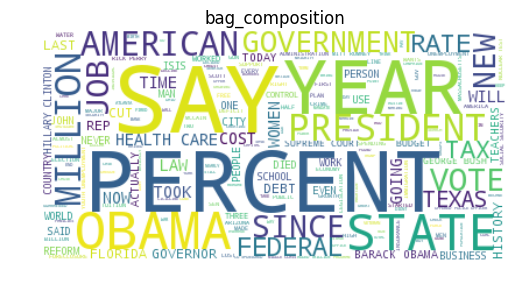

In [12]:
def wordcloud(dataframe):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in dataframe.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("bag_composition")
    plt.show()

wordcloud(newsPred['Title'])
#holy fuck!!!! this is sick!!!!!

In [17]:
def word_freq_bag(dataframe):

    counts = dict()
    bag = []
    counter = 0
    for line in dataframe:
        words = line.split()
        for each in words:
            bag.append(each)
    for word in bag:
        counts[bag[counter]] = counts.get(word,0)+1        
        counter += 1

    key = None
    value = None
    keyvalue = dict() # would like to sort by count, dicts are orderless
    for key in counts:
        value = counts[key]
        keyvalue[key] = value
        # rank in descending order of frequency, get a list of tuples sorted by the second
        # element in each tuple
        valueSort1 = sorted(keyvalue.items(), key=operator.itemgetter(1), reverse = True)
        valueSort0 = sorted(keyvalue.items(), key=operator.itemgetter(0), reverse = False)
    return(valueSort1, valueSort0, counts) 

    
response_word_freq_bag = word_freq_bag(newsPred['Title'])
# take a look at the words picked out in ascending order of 1st letter 
print(response_word_freq_bag[1])

[('"by', 1), ('"probably', 1), ('"says', 1), ('"took', 1), ('"virtually', 1), ('"who\'s', 1), ('$1.2', 1), ('$10.10', 1), ('$100', 1), ('$12', 1), ('$19.5', 1), ('$2,500', 2), ('$20,000.', 1), ('$24', 1), ('$4', 1), ('$4.9', 1), ('$41', 1), ('$50', 1), ('$6.5', 1), ('$788', 1), ('$800,000', 1), ("'disgraceful.'", 1), ("'man-made", 1), ("'terrorist", 1), ('(Affordable', 1), ('(Bob', 1), ('(Capt.', 1), ('(Jonathan', 1), ('(President', 1), ('(Syrian', 1), ('(UW)', 1), ('(and)', 1), ('(federal)', 1), ('(legally)', 1), ('(the', 1), ('--', 2), ('...', 7), ('06.', 1), ('1-in-12', 1), ('1.9', 1), ('10', 2), ('100', 1), ('100,000', 1), ('10:34', 1), ('10:45', 1), ('12', 1), ('17', 1), ('18', 1), ('1968,', 1), ('1990', 1), ('1999.', 1), ('2', 2), ('2,054th', 1), ('2-plus', 1), ('20', 2), ('2000,', 1), ('2005', 2), ('2008', 1), ('2008,', 1), ('2010', 1), ('2012,', 1), ('2013', 1), ('24', 1), ('25', 1), ('250,000', 1), ('3', 2), ('300,000', 1), ('313,850', 1), ('321,092', 1), ('35', 1), ('350,000'

We printed the frequencies of each word. To be honest, this isn't that helpful since there were definitely not words very commonly used. 

In [ ]:
#print the word frequencies in descending order
#print(response_word_freq_bag[0]) 

Oooook so I finally get all that bagging shit that NLP is important for. For a problem like classification we create "bags" where the data can be classified into such bags. 

I want to classify on the accuracy, but using the Title column. So my test/training sets are going to include bags of "barely-true", "half-true", "mostly-true", "TRUE", and "FALSE" options. 

In [19]:
print (newsPred['Accuracy'])

0        half-true
1      mostly-true
2            FALSE
3        half-true
4             TRUE
5      barely-true
6        half-true
7        half-true
8      mostly-true
9      mostly-true
10       half-true
11           FALSE
12     mostly-true
13     barely-true
14       half-true
15            TRUE
16     barely-true
17       half-true
18     mostly-true
19           FALSE
20     mostly-true
21     mostly-true
22       half-true
23     barely-true
24           FALSE
25     mostly-true
26       half-true
27           FALSE
28     mostly-true
29            TRUE
          ...     
119    mostly-true
120    mostly-true
121           TRUE
122    mostly-true
123    mostly-true
124           TRUE
125    mostly-true
126          FALSE
127     pants-fire
128      half-true
129    mostly-true
130    mostly-true
131    mostly-true
132    barely-true
133           TRUE
134          FALSE
135           TRUE
136     pants-fire
137    barely-true
138    mostly-true
139          FALSE
140    barel

Hahaha reflection: I got a lot farther in 30 minutes of using Kaggle as a reference than in like 10 hours prior of trying to create something. Be smart about your resources!! 

What's next: I  need to clean up and explore the data a little more, but this is pretty much enough to start applying algorithms. But I am hungry so I am going to stop here for today and go eat. 